In [1]:

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer,MissingIndicator, KNNImputer
from sklearn.model_selection import train_test_split, cross_validate,GridSearchCV,KFold,StratifiedKFold,cross_val_score,cross_val_predict,KFold
from sklearn.preprocessing import PowerTransformer,OneHotEncoder, StandardScaler

from sklearn.metrics import accuracy_score

import warnings; warnings.filterwarnings("ignore")

from feature_engine.encoding import OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from catboost import CatBoostClassifier,Pool
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',50)


In [70]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
y=train['PROD_CATEGORY']
ID = test['ID']
data=pd.concat((train,test)).reset_index(drop=True).copy()
y=train['PROD_CATEGORY']
data=data.drop(columns=['PROD_CATEGORY','ID'],axis=1)

data['AGE']=data['AGE'].fillna(-99)
#data['PINCODE']=data['PINCODE'].fillna(-99)

train=data[:len(train)]
test=data[len(train):]

In [71]:
def preprocesing(df):    
    df['OCC']=df['OCC'].apply(lambda x: 'others' if x in ['salaried','student','missing'] else x)
    df['INCOME_SEGMENT']=df['INCOME_SEGMENT'].apply(lambda x: -9999 if x in [10,-99] else x)
    df['QUALITY_SCORE_BAND']=df['QUALITY_SCORE_BAND'].apply(lambda x: -9999 if x ==1 else x)
    df['PROSPERITY_INDEX_BAND']=df['PROSPERITY_INDEX_BAND'].replace("Missing",'missing')
    return df
#data=preprocesing(data)
train=preprocesing(train)
test=preprocesing(test)

In [72]:
def feature_engineering_2(df):    
    a=df['PINCODE'].apply(lambda x: str(x)[:2])
    a=a.replace('na',np.nan)
    a=a.astype("float64")

    df['states']=a.apply(lambda x: 'delhi' if x==11.0 else 'haryana' if (x==12 or x==13) else 'punjab' if (x>=14 and x<=16) else 
            'himachal' if x==17 else
           'jammu_kashmir' if (x==18 or x==19) else 'up_uk' if (x>=20 and x<=28) else 
           'rajasthan' if (x>=30 and x<=34) else 'gujarat' if (x>=36 and x<=39) else 'maharashtra' if (x>=40 and x<=44) else
    'mp_cht' if (x>=45 and x<=49) else 'ap' if (x>=50 and x<=53) else 'karnataka' if (x>=56 and x<=59) else
    'tn' if (x>=60 and x<=64) else 'kerela' if (x>=67 and x<=69) else 'wb' if (x>=70 and x<=74) else
            'orissa' if (x>=75 and x<=77) else
    'assam' if x==78 else 'north_eastern' if x==79 else 'bihar_jk' if (x>=80 and x<=85) else 
    'army_postal_service' if (x>=90 and x<=99) else 'n/a')

    b=df['PINCODE'].apply(lambda x: str(x)[:1])
    b=b.replace('n',np.nan)
    b=b.astype("float64")

    df['region']=b.apply(lambda x: 'north' if (x==1 or x==2) else 'west' if (x==3 or x==4) else 'south' if (x==5 or x==6) else
           'east' if (x==7 or x==8) else 'army_postal_service' if x==9 else 'n/a' )
    df=df.drop("PINCODE",axis=1)
    return df
#data=feature_engineering_2(data)
train=feature_engineering_2(train)
test=feature_engineering_2(test)

In [73]:
def feature_engineering_3(df):    
    df['month']=df['ISSUANCE_MONTH'].apply(lambda x: x.split('-')[0])
   # df['AGE_cat']=df['AGE'].apply(lambda x: 0 if x>=60 else 1 if x>=50 else 2 if x>=35 else 3 if x>=25 else 4)
    df=df.drop('ISSUANCE_MONTH',axis=1)
    return df
#data=feature_engineering_3(data)
train=feature_engineering_3(train)
test=feature_engineering_3(test)

In [74]:
def feature_engineering_4(df):
    df['f1']=np.where( [df['QUALITY_SCORE_BAND'].isin(['graduate_plus','masters_plus'])], 1,0).transpose()
    df['f2']=np.where( [df['QUALITY_SCORE_BAND'].isin(['graduate_plus'])], 1,0).transpose()
    df['f3']=np.where( [df['OCC'].isin(['agriculture','retired','salaried','student'])], 0,1).transpose()
    df['f4']=np.where( [df['OCC'].isin(['business','salaried_pvt'])], 1,0).transpose()
    df['f5']=np.where( [df['INCOME_SEGMENT'].isin([1,2])], 0,1).transpose()
    df['f6']=np.where( [df['PROSPERITY_INDEX_BAND'].isin(['Very_high'])], 1,0).transpose()
    df['f7']=np.where( [df['PROSPERITY_INDEX_BAND'].isin(['Medium'])], 1,0).transpose()
    df['f8']=np.where( [df['PROSPERITY_INDEX_BAND'].isin(['High'])], 1,0).transpose()
    df['f9']=np.where( [df['QUALITY_SCORE_BAND'].isin([5,6])], 1,0).transpose()
    df['f10']=np.where( [df['QUALITY_SCORE_BAND'].isin([3,4])], 1,0).transpose()
    return df
#data=feature_engineering_4(data)
train=feature_engineering_4(train)
test=feature_engineering_4(test)

In [75]:
def cat_encode(df):
    df['EDUCATION']=df['EDUCATION'].apply(lambda x: 5 if x=='masters_plus' else 4 if x=='graduate_plus' else 3 if x=='higher_secondary' else 2 if x=='matriculation' else 1 if x =='missing' else 0)
    df['PROSPERITY_INDEX_BAND']=df['PROSPERITY_INDEX_BAND'].apply(lambda  x: 5 if x=='Very_high' else 4 if x=='High' else 3 if x=='Medium' else 2 if x=='Low' else 1 if x =='missing' else 0)
    return df

#data=cat_encode(data)
train=cat_encode(train)
test=cat_encode(test)

In [76]:
encoder=OrdinalEncoder(encoding_method='arbitrary')

cat_cols=[col for col in test.columns if test[col].dtype=='object']


data=pd.concat((train,test)).reset_index(drop=True)
data[cat_cols]= encoder.fit_transform(data[cat_cols])
train=data[:len(train)]
test=data[len(train):]


In [78]:
params = {
    'n_estimators':500,
    'learning_rate': 0.1,
    'random_seed': 42,
      'max_depth': 8,
    'use_best_model':True,
    'early_stopping_rounds':200,'loss_function':'MultiClass',
                          'eval_metric':'Accuracy'
}

lb=LabelEncoder()
y_=lb.fit_transform(y)


kf=StratifiedKFold(n_splits=5)
pred_cat_test = np.zeros(len(test))
train_scores =[]
val_score =[]
oof_pred=pd.DataFrame({})
for fold_idx, (train_index, test_index) in enumerate(kf.split(train,y_)):
    X_train,X_test,y_train,y_test= train.loc[train_index] ,train.loc[test_index],y_[train_index], y_[test_index]  
  
    
    cat_cols=[col for col in X_train.columns if X_train[col].dtype=='object']
    
    train_pool = Pool(X_train, y_train,cat_features=cat_cols)
    validate_pool = Pool(X_test, y_test,cat_features=cat_cols)

    cat_clf = CatBoostClassifier(**params).fit(train_pool, eval_set=validate_pool,  verbose=10)


    pred_1=cat_clf.predict(X_train)
    pred_2=cat_clf.predict(X_test)
    
    
    lr_test = cat_clf.predict(test) / 5
    pred_cat_test += [item for sublist in lr_test for item in sublist] 
   
    
 
    training_accuracy=accuracy_score(y_train,pred_1)
    val_accuracy=accuracy_score(y_test,pred_2)
    
    print(f'fold no ----->{fold_idx+1}')
    print(f'training_log_loss-->>>{training_accuracy}')
    print(f'val_log_loss-->>>{val_accuracy}')
          
    print('*******************************************')
    print('*******************************************')
    

    train_scores.append(training_accuracy)
    val_score.append(val_accuracy)

print(f'train mean score  is ---->{np.mean(train_scores)}')
print(f'val mean score  is ---->{np.mean(val_score)}')  

final=lb.inverse_transform(pred_cat_test.round().astype(int))

0:	learn: 0.6766667	test: 0.6577778	best: 0.6577778 (0)	total: 8.79ms	remaining: 4.39s
10:	learn: 0.6869444	test: 0.6666667	best: 0.6700000 (2)	total: 110ms	remaining: 4.87s
20:	learn: 0.7058333	test: 0.6600000	best: 0.6700000 (2)	total: 212ms	remaining: 4.83s
30:	learn: 0.7152778	test: 0.6588889	best: 0.6700000 (2)	total: 311ms	remaining: 4.71s
40:	learn: 0.7300000	test: 0.6655556	best: 0.6700000 (2)	total: 416ms	remaining: 4.65s
50:	learn: 0.7377778	test: 0.6611111	best: 0.6700000 (2)	total: 519ms	remaining: 4.57s
60:	learn: 0.7497222	test: 0.6655556	best: 0.6700000 (2)	total: 623ms	remaining: 4.48s
70:	learn: 0.7583333	test: 0.6655556	best: 0.6700000 (2)	total: 722ms	remaining: 4.36s
80:	learn: 0.7652778	test: 0.6644444	best: 0.6700000 (2)	total: 820ms	remaining: 4.24s
90:	learn: 0.7752778	test: 0.6666667	best: 0.6700000 (2)	total: 918ms	remaining: 4.13s
100:	learn: 0.7825000	test: 0.6700000	best: 0.6722222 (97)	total: 1.01s	remaining: 4.01s
110:	learn: 0.7886111	test: 0.6744444	bes

20:	learn: 0.6958333	test: 0.6700000	best: 0.6733333 (1)	total: 203ms	remaining: 4.64s
30:	learn: 0.7050000	test: 0.6788889	best: 0.6800000 (27)	total: 300ms	remaining: 4.54s
40:	learn: 0.7222222	test: 0.6777778	best: 0.6811111 (32)	total: 393ms	remaining: 4.39s
50:	learn: 0.7305556	test: 0.6755556	best: 0.6811111 (32)	total: 494ms	remaining: 4.35s
60:	learn: 0.7408333	test: 0.6833333	best: 0.6833333 (60)	total: 582ms	remaining: 4.19s
70:	learn: 0.7455556	test: 0.6800000	best: 0.6844444 (61)	total: 674ms	remaining: 4.07s
80:	learn: 0.7566667	test: 0.6822222	best: 0.6844444 (61)	total: 769ms	remaining: 3.98s
90:	learn: 0.7669444	test: 0.6811111	best: 0.6844444 (61)	total: 866ms	remaining: 3.89s
100:	learn: 0.7750000	test: 0.6800000	best: 0.6844444 (61)	total: 963ms	remaining: 3.8s
110:	learn: 0.7872222	test: 0.6811111	best: 0.6844444 (61)	total: 1.05s	remaining: 3.69s
120:	learn: 0.7947222	test: 0.6844444	best: 0.6844444 (61)	total: 1.15s	remaining: 3.59s
130:	learn: 0.8041667	test: 0.6

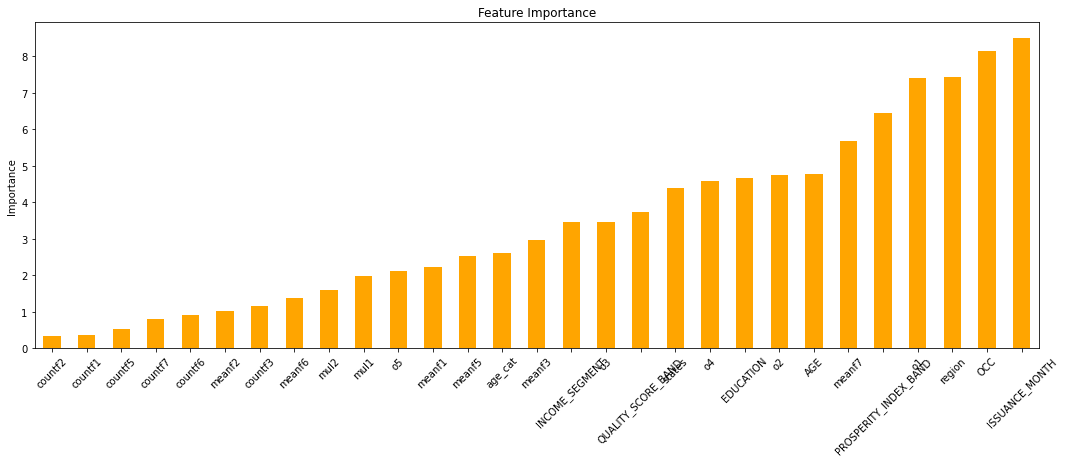

In [792]:
cat_clf.feature_importances_
features_dict = dict(zip(train.columns, list(cat_clf.feature_importances_)))
features_df = pd.DataFrame(features_dict, index=[0])
features_df.T.sort_values(by=0).plot.bar(title="Feature Importance", legend=False, 
                                    figsize=(18,6),color='orange');

plt.xticks(rotation=45);

plt.ylabel("Importance");

In [79]:
submission = pd.DataFrame({"ID":ID,"PROD_CATEGORY":final})
submission.to_csv('submission_98.csv', index=False)